# Example: JUSTICE - IAM Simulation Run

In [2]:
import pandas as pd
import numpy as np

from src.util.data_loader import DataLoader
from src.util.enumerations import *
from src.util.model_time import TimeHorizon


### Setting Some Dummy Policy Levers

JUSTICE model has two policy levers: Savings rate and Emissions Control Rate. To run the simulation version of the model, we need to feed the policy levers with some values. The range of both savings rate and emissions control rate are from 0 to 1.0 corresponding to 0% to 100%. 

Here we set the savings rate to the intial savings rate data of the different regions and increase it linearly to the optimal savings rate of original DICE/RICE implementation

#### Lever: Fixed Savings rate

Savings rate array can be passed during initialization of JUSTICE. 
If not, fixed savings rate is used. For fixed savings rate, elasticity of marginal utility of consumption and pure rate of time preference is required during init.

(57, 58)


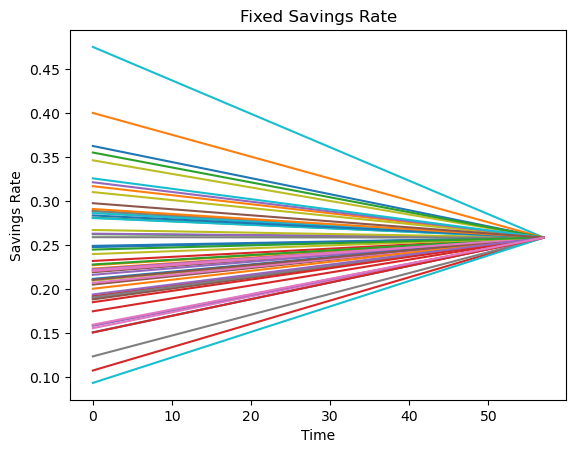

In [2]:
import matplotlib.pyplot as plt
# Load the data
data_loader = DataLoader()

# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

fixed_savings_rate = np.copy(data_loader.SAVING_RATE_INIT_ARRAY).reshape(-1, 1)
# fixed_savings_rate Validated with RICE50 for timestep 1 and 5

optimal_long_run_savings_rate = 0.2582781457 #self.get_optimal_long_run_savings_rate()
time = time_horizon.data_time_horizon


for t in range(2, (len(time) + 1)):

    next_rate = data_loader.SAVING_RATE_INIT_ARRAY + (
        optimal_long_run_savings_rate - data_loader.SAVING_RATE_INIT_ARRAY
    ) * ((t - 1) / (len(time) - 1))
    # append to the fixed savings rate array for each year
    fixed_savings_rate = np.column_stack((fixed_savings_rate, next_rate))

# plot the savings rate
print(fixed_savings_rate.shape)
# Fixed savings rate is of shape (57,58) where 58 is the time horizon to be plotted on x axis. 57 are the different regions so loop through them
for i in range(fixed_savings_rate.shape[0]):
    plt.plot(fixed_savings_rate[i, :])

plt.title("Fixed Savings Rate")
plt.xlabel("Time")
plt.ylabel("Savings Rate")
plt.show()

#### Lever: Linear Emissions Control Rate

Here the emission control starts at 0, meaning no emission control and increases linearly to 100% emission control rate depending on the transistion start year and the full emission control year.

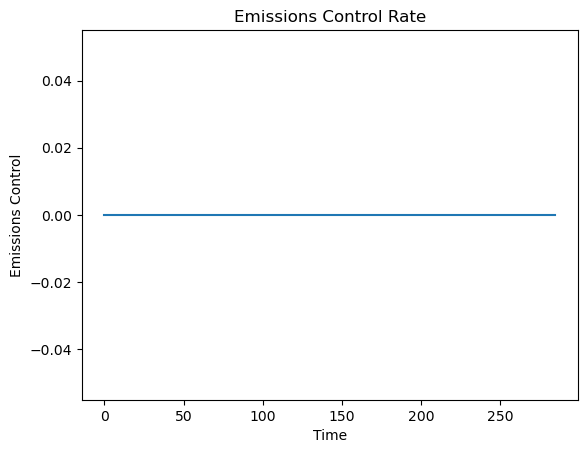

In [3]:
# Load the data
data_loader = DataLoader()

# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

#emissions control rate borrowed from emissions module

#Variables to be changed/deleted later
miu_initial = 0.0
min_miu = 0.0 #0.0 #1.0
min_miu_year = 2055 #9-original #8 in this model  # 2060
max_miu = 0.0
max_miu_year = 2200 #38-original #37 in this model #2205

t_min_miu = time_horizon.year_to_timestep(min_miu_year, timestep=1)
t_max_miu = time_horizon.year_to_timestep(max_miu_year, timestep=1)

#Initialize emissions control rate
emissions_control_rate = np.zeros((len(data_loader.REGION_LIST), len(time_horizon.model_time_horizon)))

for t in range(len(time_horizon.model_time_horizon)):
    
    if t < t_min_miu:       # Before time of transition
        emissions_control_rate[:,t] = min_miu
    elif t <= t_max_miu:   # Transition
        # During the transition
        emissions_control_rate[:, t] = min_miu + (max_miu - min_miu) * (t - t_min_miu)/(t_max_miu - t_min_miu)
    else:                   # After the transition
        emissions_control_rate[:, t] = max_miu


from matplotlib import pyplot as plt
plt.plot(emissions_control_rate[0, :])
plt.title("Emissions Control Rate")
plt.xlabel("Time")
plt.ylabel("Emissions Control")
plt.show()

## 1. JUSTICE Initialisation

JUSTICE Runs on 8 SSP-RCP scenarios. The SSP-RCP scenarios can be seen with this piece of code

In [4]:
# Get list of Scenarios from Enum

for idx, scenarios in enumerate(list(Scenario.__members__.keys())):
    print(idx, scenarios)

0 SSP119
1 SSP126
2 SSP245
3 SSP370
4 SSP434
5 SSP460
6 SSP534
7 SSP585


Here we initiate the model with a scenario index corresponding to a particular SSP-RCP scenario. The scenario index is from 0 to 7. The scenario index is the same as the index of the SSP-RCP scenarios in the list above.

The initialization phase of JUSTICE loads all the economic and climate data, creates all the arrays to store the results and sets the initial values of the variables.

In [3]:
from src.model import JUSTICE
from src.util.enumerations import *

# Instantiate the model
scenarios = 2
model = JUSTICE(
        scenario =scenarios,
        economy_type=Economy.NEOCLASSICAL,
        damage_function_type=DamageFunction.KALKUHL,
        abatement_type=Abatement.ENERDATA,
        social_welfare_function=WelfareFunction.UTILITARIAN,
        
        enable_damage_function=True,
        enable_abatement=True,
        economy_endogenous_growth=True,
        # climate_ensembles=570, # This is to select a specific climate ensemble
    )

/Users/palokbiswas/miniforge3/envs/justice-env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 2. Run

The run function runs the model for a particular scenario index with the given policy lever setting. The run function returns the results of the simulation.


In [4]:
model.run(emission_control_rate = emissions_control_rate, endogenous_savings_rate=True) #savings_rate = fixed_savings_rate, 

## 3. Evaluate - SWF - and Generated Output Datasets

Evaluation Phase Extracts the results from the simulation and also applies the social welfare function to compute the welfare

In [5]:
datasets = model.evaluate() # Get the results of the simulation run

print(model.get_outcome_names()) # Get the list of outcomes from the simulation run

dict_keys(['gross_economic_output', 'net_economic_output', 'consumption', 'consumption_per_capita', 'damage_cost_per_capita', 'abatement_cost_per_capita', 'emissions', 'regional_temperature', 'global_temperature', 'damage_fraction', 'economic_damage', 'abatement_cost', 'carbon_price', 'spatially_aggregated_welfare', 'temporally_disaggregated_welfare', 'welfare'])


## 3.1 Stepwise Run & Evaluate

Instead of running the entire model horizon, we can run the model step by step. This is useful for integrating the model with EMODPS framework for adaptive policymaking or RL framework.

In [ ]:
for timestep in range(len(time_horizon.model_time_horizon)):    
    model.stepwise_run( emission_control_rate = emissions_control_rate[:, timestep], timestep=timestep, endogenous_savings_rate=True) #savings_rate = fixed_savings_rate[:, timestep],
    datasets = model.stepwise_evaluate(timestep=timestep)
    


Extracting the data from the outcome dictionary to the different variables

In [6]:
#Load the data
gross_output = datasets['gross_economic_output'] 
net_output = datasets['net_economic_output']
consumption = datasets['consumption'] #(57, 286, 1001)
cpc = datasets['consumption_per_capita'] #(57, 286, 1001)
emis_control = datasets['emissions'] #(57, 286, 1001)
reg_temp = datasets['regional_temperature']
temp = datasets['global_temperature'] # (286, 1001)
damages = datasets['economic_damage'] #(57, 286, 1001)
abatecost = datasets['abatement_cost'] #(57, 286, 1001)
spatially_aggregated_welfare = datasets['spatially_aggregated_welfare'] # (286,)
temporally_disaggregated_welfare = datasets['temporally_disaggregated_welfare']  # (286,)
welfare = datasets['welfare'] # float
abatement_cost_per_capita = datasets["abatement_cost_per_capita"]
damage_cost_per_capita = datasets["damage_cost_per_capita"]


## 4. Visualize

We can visualize the timeseries of the different outcomes that we extracted in the previous step

In [ ]:
# Read hdf5 file
import h5py

# # Save the datasets as hdf5 file
# with h5py.File("data/reevaluation/justice_output_util_150_endo.h5", "w") as f:
#     for key, value in datasets.items():
#         f.create_dataset(key, data=value)

# Read the dictionary from the hdf5 file
with h5py.File("data/reevaluation/justice_output_util_150_exo.h5", "r") as f:
    datasets = {key: f[key][()] for key in f.keys()}

gross_output = datasets['gross_economic_output'] 
net_output = datasets['net_economic_output']
consumption = datasets['consumption'] #(57, 286, 1001)
cpc = datasets['consumption_per_capita'] #(57, 286, 1001)
emis_control = datasets['emissions'] #(57, 286, 1001)
reg_temp = datasets['regional_temperature']
temp = datasets['global_temperature'] # (286, 1001)
damages = datasets['economic_damage'] #(57, 286, 1001)
abatecost = datasets['abatement_cost'] #(57, 286, 1001)
spatially_aggregated_welfare = datasets['spatially_aggregated_welfare'] # (286,)
temporally_disaggregated_welfare = datasets['temporally_disaggregated_welfare']  # (286,)
welfare = datasets['welfare'] # float
abatement_cost_per_capita = datasets["abatement_cost_per_capita"]
damage_cost_per_capita = datasets["damage_cost_per_capita"]
    

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create list of all the data arrays
data_list = [net_output, cpc, emis_control, gross_output, damages, abatecost, reg_temp]
titles = ['Net Economic Output', 'Consumption per Capita', 'Emissions', 'Gross Economic Output', 'Economic Damages', 'Abatement Cost', 'Regional Temperature']

region_index = 55

# Create a figure with 2 rows and 3 columns
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axs array to iterate over it
axs = axs.flatten()

# Iterate over the data arrays and plot them
for i, loaded_data in enumerate(data_list):
    # Select the region based on region_index
    region_data = loaded_data[region_index, :, :]
    
    # Create a line plot for each scenario
    for j in range(region_data.shape[1]):
        sns.lineplot(x=time_horizon.model_time_horizon, y=region_data[:, j], ax=axs[i])
    
    # Set the title and axis labels
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Value')
    
# Remove the unused subplots
for i in range(len(data_list), len(axs)):
    fig.delaxes(axs[i])

# Adjust the layout and spacing
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)





In [ ]:
damage_frac = model.damage_function.total_damage_fraction

# Get the max value
max_value = np.max(damage_frac)


NameError: name 'net_output' is not defined

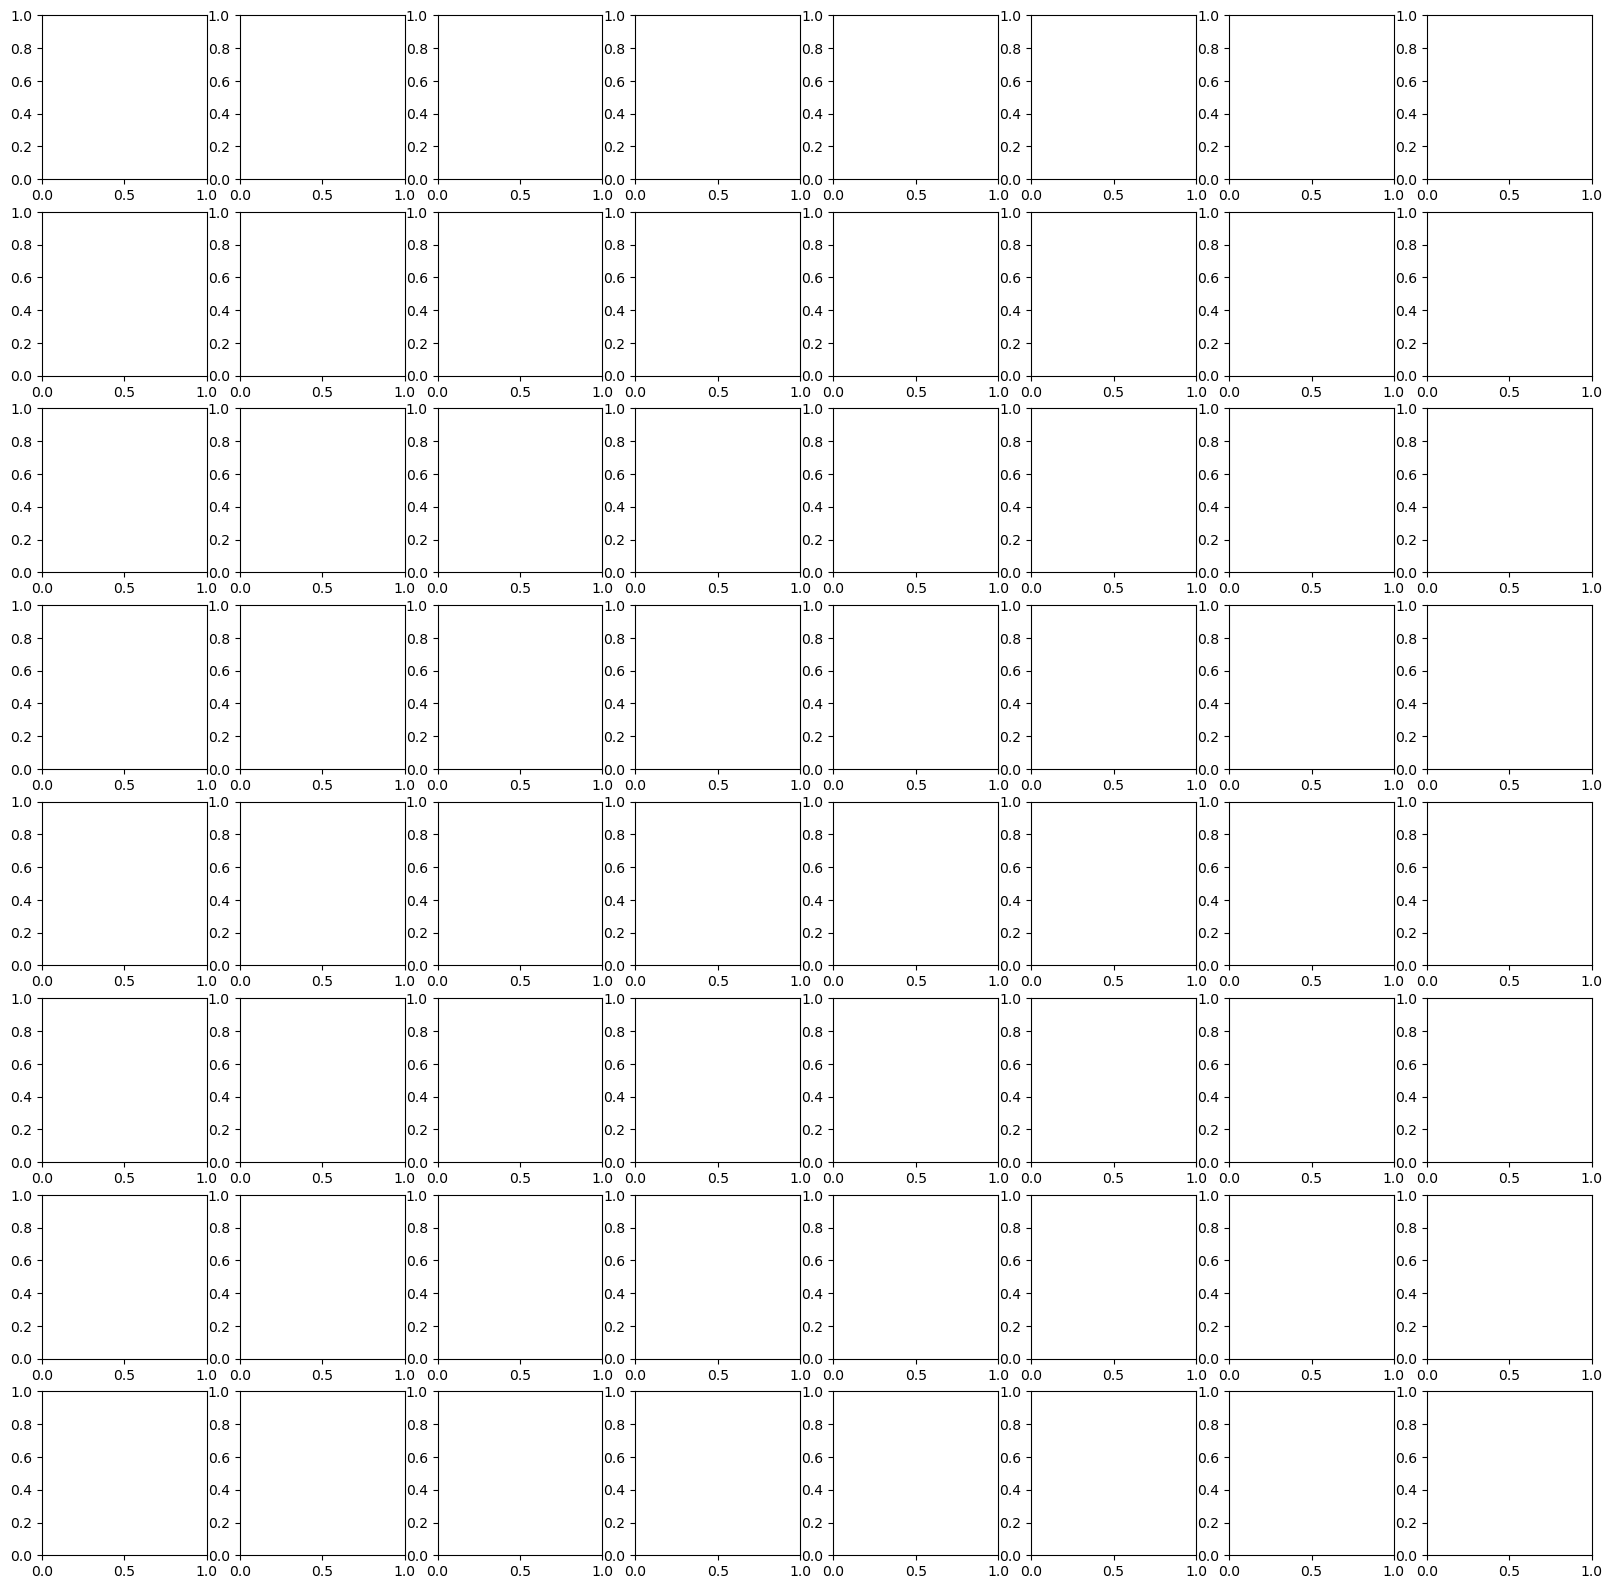

In [5]:

import matplotlib.pyplot as plt
import json
import numpy as np
from src.util.data_loader import DataLoader
# Import data loader
data_loader = DataLoader()

color = 'red'
# Assuming net_output, time_horizon, and region_codes are already defined
region_codes = data_loader.REGION_LIST
# Load region names
with open('data/input/rice50_region_names.json') as f:
    region_names = json.load(f)

# Define the number of regions
num_regions = 57

# Define the number of rows and columns for the subplots
num_rows = int(np.ceil(num_regions / 8))  # Adjust columns and rows accordingly
num_cols = 8  # This is a suggestion, you can change the layout as needed

# Create the figure and the axes array
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
axes = axes.flatten()

# Plot for each region
for i in range(num_regions):
    region_data = net_output[i, :, :]
    region_data_median = np.median(region_data, axis=1)
    region_data_max = np.max(region_data, axis=1)
    region_data_min = np.min(region_data, axis=1)

    ax = axes[i]
    ax.plot(time_horizon.model_time_horizon, region_data_median, label='Median', color=color)
    ax.fill_between(time_horizon.model_time_horizon, region_data_min, region_data_max, alpha=0.2, label='Min-Max Range', color=color)
    ax.set_title(region_names[region_codes[i]])
    ax.set_xlabel('Year')
    ax.set_ylabel('Net Economic Output')
    # ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [8]:
# Print the list of region names with their index
for i, region in enumerate(region_names):
    print(data_loader.REGION_LIST[i], i)

arg 0
aus 1
aut 2
bel 3
bgr 4
blt 5
bra 6
can 7
chl 8
chn 9
cor 10
cro 11
dnk 12
egy 13
esp 14
fin 15
fra 16
gbr 17
golf57 18
grc 19
hun 20
idn 21
irl 22
ita 23
jpn 24
meme 25
mex 26
mys 27
nde 28
nld 29
noan 30
noap 31
nor 32
oeu 33
osea 34
pol 35
prt 36
rcam 37
rcz 38
rfa 39
ris 40
rjan57 41
rom 42
rsaf 43
rsam 44
rsas 45
rsl 46
rus 47
slo 48
sui 49
swe 50
tha 51
tur 52
ukr 53
usa 54
vnm 55
zaf 56


In [ ]:
# exogenous 

import matplotlib.pyplot as plt
import numpy as np

color = 'red'

# Assuming net_output, time_horizon, and region_codes are already defined

# Load region names
with open('data/input/rice50_region_names.json') as f:
    region_names = json.load(f)

# Define the number of regions
num_regions = 57

# Define the number of rows and columns for the subplots
num_rows = int(np.ceil(num_regions / 8))  # Adjust columns and rows accordingly
num_cols = 8  # This is a suggestion, you can change the layout as needed

# Create the figure and the axes array
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
axes = axes.flatten()

# Plot for each region
for i in range(num_regions):
    region_data = net_output[i, :, :]
    region_data_median = np.median(region_data, axis=1)
    region_data_max = np.max(region_data, axis=1)
    region_data_min = np.min(region_data, axis=1)

    ax = axes[i]
    ax.plot(time_horizon.model_time_horizon, region_data_median, label='Median', color=color)
    ax.fill_between(time_horizon.model_time_horizon, region_data_min, region_data_max, alpha=0.2, label='Min-Max Range', color=color)
    ax.set_title(region_names[region_codes[i]])
    ax.set_xlabel('Year')
    ax.set_ylabel('Net Economic Output')
    # ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [2]:
# Read csv file
import pandas as pd
df = pd.read_csv('data/optimized_rbf_weights/150k/UTIL/150373.csv')

# for column welfare, find the index of the min value and print the min value
column_of_interest = 'years_above_temperature_threshold'
min_value = df[column_of_interest].min()
min_index = df[column_of_interest].idxmin()
print(min_value, min_index)

85.23476523476523 22


In [14]:
list(Scenario.__members__.keys())

['SSP119',
 'SSP126',
 'SSP245',
 'SSP370',
 'SSP434',
 'SSP460',
 'SSP534',
 'SSP585']

## Run All Scenarios

In [4]:
from src.model import JUSTICE
from src.util.enumerations import *

# Create a dictionary to store the data for each scenario
scenario_data = {}


for idx, scenarios in enumerate( ['SSP119', 'SSP245', 'SSP370', 'SSP434', 'SSP585'] ): # list(Scenario.__members__.keys())
    print(idx, scenarios)
    
    # Initialize the model
    model = JUSTICE(
            scenario =idx,
            economy_type=Economy.NEOCLASSICAL,
            damage_function_type=DamageFunction.KALKUHL,
            abatement_type=Abatement.ENERDATA,
            social_welfare_function=WelfareFunction.UTILITARIAN,

            enable_damage_function=True,
            enable_abatement=True,
            economy_endogenous_growth=False,
        )
    
    # Run the model
    model.run(emission_control_rate = emissions_control_rate, endogenous_savings_rate=True)


    # Evaluate the model
    scenario_data[scenarios] = model.evaluate()


/Users/palokbiswas/miniforge3/envs/justice-env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


0 SSP119
1 SSP245
2 SSP370
3 SSP434
4 SSP585


## The Codes after this point is for testing purpose. Not example codes.

# ______________________________________________________________________________________________________________________

## Main Analysis Starts Here

## Neural Networks Test for EMODPS

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the architecture of neural network
class Net(nn.Module):
    def __init__(self, input_size, output_size, first_layer_size, hidden_layers, hidden_layer_size, weights=None, biases=None):
        super(Net, self).__init__()
        self.first_layer = nn.Linear(input_size, first_layer_size)
        
        if weights is not None and biases is not None:
            self.first_layer.weight = nn.Parameter(torch.Tensor(weights[0]))
            self.first_layer.bias = nn.Parameter(torch.Tensor(biases[0]))
            
        self.hidden_layers = nn.ModuleList()
        for i in range(hidden_layers - 1):
            hidden_layer = nn.Linear(first_layer_size, hidden_layer_size)
            if weights is not None and biases is not None:
                hidden_layer.weight = nn.Parameter(torch.Tensor(weights[i+1]))
                hidden_layer.bias = nn.Parameter(torch.Tensor(biases[i+1]))
            self.hidden_layers.append(hidden_layer)
            
            first_layer_size = hidden_layer_size

        self.last_layer = nn.Linear(first_layer_size, output_size)

        if weights is not None and biases is not None:
            self.last_layer.weight = nn.Parameter(torch.Tensor(weights[-1]))
            self.last_layer.bias = nn.Parameter(torch.Tensor(biases[-1]))

    def forward(self, x):
        x = F.leaky_relu(self.first_layer(x), 0.1)
        for hidden_layer in self.hidden_layers:
            x = F.leaky_relu(hidden_layer(x), 0.1)
        x = torch.sigmoid(self.last_layer(x))
        return x

In [ ]:
import numpy as np

# # Create a 57 by 57 matrix of value 0.5
# weights = np.full((57, 57), 0.5)
# # Create a shape (57) matrix of value 0.5
# biases = np.full((57), 0.5)
# Assumption - MOEA provides these values
layer_1_weights = np.full((57, 57), 0.5)  # replace with actual value from MOEA
layer_2_weights = np.full((57, 57), 0.5)  # replace with actual value from MOEA

layer_1_biases = np.full((57), 0.0)  # replace with actual value from MOEA
layer_2_biases = np.full((57), 0.0)  # replace with actual value from MOEA

# Stack them into lists
weights = [layer_1_weights, layer_2_weights]
biases = [layer_1_biases, layer_2_biases]

model = Net(input_size=57, output_size=57, first_layer_size=57, hidden_layers=1, hidden_layer_size=57, weights=weights, biases=biases)

In [ ]:
import numpy as np

# Create a 1 by 57 numpy array of 0.5s
input_data = np.full((1, 57), 0.2)

# Convert the numpy array to a torch tensor
input_data_tensor = torch.Tensor(input_data)

# Pass the tensor through the model
output = model(input_data_tensor)

output = output.detach().numpy()

# Print the output
print(output)

In [ ]:
constrained_emission_control_rate = []
# Plot emissions_control_rate for each region in subplots
import matplotlib.pyplot as plt
# Average emissions_control_rate across all scenarios
average_emissions_control_rate = np.mean(constrained_emission_control_rate, axis=2)

# Convert average_emissions_control_rate timestep to year
average_emissions_control_rate_df = pd.DataFrame(average_emissions_control_rate)
average_emissions_control_rate_df.columns = [time_horizon.timestep_to_year(i, 1) for i in range(286)]

# Plot all the regions in a single plot
plt.figure(figsize=(15,5))

# Get region names
regions_str = data_loader.REGION_LIST

for i in range(len(regions_str)):
    plt.plot(average_emissions_control_rate_df.iloc[i, :])

#plt.legend(regions_str)
# Add fine grid with 1 year interval
plt.xticks(np.arange(2015, 2301, 5))

# Rotate x labels for better visibility
plt.xticks(rotation=90)
plt.xlabel('Year')
plt.ylabel('Emissions Control Rate')
plt.title('Mean Emissions Control Rate across regions')
plt.show()


In [ ]:

from src.util.enumerations import WelfareFunction, get_welfare_function_name
from config.default_parameters import SocialWelfareDefaults


# TODO should have a configuration file for optimizations
social_welfare_function = WelfareFunction.EGALITARIAN
social_welfare_function = WelfareFunction.PRIORITARIAN
social_welfare_function = WelfareFunction.UTILITARIAN
social_welfare_function = WelfareFunction.SUFFICIENTARIAN
# Get Social Welfare Defaults
social_welfare_defaults = SocialWelfareDefaults().get_defaults(
    social_welfare_function.value[1]
)

elasticity_of_marginal_utility_of_consumption = social_welfare_defaults["elasticity_of_marginal_utility_of_consumption"]
pure_rate_of_social_time_preference = social_welfare_defaults["pure_rate_of_social_time_preference"]
risk_aversion = social_welfare_defaults["inequality_aversion"]
sufficiency_threshold = social_welfare_defaults["sufficiency_threshold"]
egality_strictness = social_welfare_defaults["egality_strictness"]

print(social_welfare_function.value[1])
nfe = 5000

filename = f"{social_welfare_function.value[1]}_{nfe}.tar.gz"
print(filename)



In [ ]:
# 100k Viz
from src.util.visualizer import visualize_tradeoffs
visualize_tradeoffs(
    path_to_data='data/optimized_rbf_weights/tradeoffs',
    path_to_output="data/plots",
    input_data = ['UTIL_100068_s521475.csv'], #, 'PRIOR_101400_s1644652.csv'], #'UTIL_100024_s1644652.csv'["UTIL_100049.csv", "SUFF_102924.csv", "EGAL_101948.csv", "PRIOR_101765.csv"], 
    column_labels = ["Welfare", "Years above \nTemperature Threshold", "Damages", "Abatement"],
    legend_labels = ["Utilitarian"], #["Utilitarian", "Sufficientarian", "Egalitarian", "Prioritarian"],
    linewidth=0.84,
    alpha=0.05,
    feature_adjustment_value=300,
    objective_of_interest=0,
    show_best_solutions=False,
    scaling=False,
    )

In [ ]:
import pandas as pd
"""
10K
            Max                Min
    Util:   103.81228045415136 103.4844246523926
    Egal:   414.02329209797296 411.62632633121007
    Prior:  414.0439514015804  411.5511882634973
    Suff:   103.79372232319255 103.4903588180675

100K
            Max                Min
    Util:   103.83587393570603 103.48137813079882
    Egal:   413.998482125867   411.38869134509866
    Prior:  414.0583351228716  411.3949039937641
    Suff:   103.83485353599104 103.48622581339748    
"""

input_data = ["UTIL_10158.csv", "EGAL_10164.csv", "PRIOR_10049.csv", "SUFF_10130.csv"]
input_data_100k = ["UTIL_100049.csv", "EGAL_101948.csv", "PRIOR_101765.csv", "SUFF_102924.csv"]

df = pd.read_csv('data/optimized_rbf_weights/tradeoffs/'+input_data_100k[0])
df = df.iloc[:, -4:]

min_welfare_index = df['welfare_utilitarian'].idxmin()

max_val = df.iloc[:, 0].max()
min_val = df.iloc[:, 0].min()

# Arrange the data prior in descending order of welfare_utilitarian
# df = df.sort_values(by='welfare_utilitarian', ascending=False)
# df.columns[0]
df = df.sort_values(by=df.columns[0], ascending=True)
print("Max & Min: ", max_val , min_val)
print("index: ", min_welfare_index)

#### Sorting out the best performing policies in all dimensions

In [ ]:
from src.util.output_data_processor import get_best_performing_policies

input_data = [
    "UTIL_100024_s1644652.csv",
    "PRIOR_101400_s1644652.csv",
    # "PRIOR_101765.csv",
    # "SUFF_102924.csv",
]
lowest_n_percent = 0.51
data_path = "data/optimized_rbf_weights/tradeoffs/"
list_of_objectives = [
        "welfare",
        "years_above_temperature_threshold",
        "welfare_loss_damage",
        "welfare_loss_abatement",
    ]

indices_list = get_best_performing_policies(
    input_data, lowest_n_percent, data_path, list_of_objectives
)
print(indices_list)

In [ ]:
from src.util.output_data_processor import get_best_performing_policies
# input_data=[
#     "UTIL_100024_s1644652.csv",
#     "PRIOR_101400_s1644652.csv",
#     "SUFF_100090_s9845531.csv",
#     "EGAL_100417_s1644652.csv",
# ]
# direction_of_optimization=[
#     "min",
#     "min",
#     "max",
#     "max",
# ],
# lowest_n_percent=0.51,


list_of_pareto_optimal_policies = get_best_performing_policies(
    input_data=[
        "UTIL_100024_s1644652.csv",
        "PRIOR_101400_s1644652.csv",
        "SUFF_100090_s9845531.csv",
        "EGAL_100417_s1644652.csv",
    ],
    lowest_n_percent=0.51,
    data_path="data/optimized_rbf_weights/tradeoffs",
    list_of_objectives=[
    "welfare",
    "years_above_temperature_threshold",
    "welfare_loss_damage",
    "welfare_loss_abatement",
    ],
    direction_of_optimization=[
        "min",
        "min",
        "max",
        "max",
    ],
)

print(list_of_pareto_optimal_policies)

In [ ]:
list_of_objectives=[
    "welfare",
    "years_above_temperature_threshold",
    "welfare_loss_damage",
    "welfare_loss_abatement",
]

for index, string in enumerate(list_of_objectives):
    print(f"Index: {index}, String: {string}")
    print(index, string)


In [ ]:
list_of_objectives[0]

In [ ]:
for i in range(len(list_of_objectives)):
    print(i, list_of_objectives[i])

In [ ]:
# Python3 code to iterate over a list
list = [1, 3, 5, 7, 9]
  
# Using enumerate() 
for i, val in enumerate(list_of_objectives):
    print (i, ",",val)

In [ ]:
from src.util.visualizer import plot_timeseries

fig = plot_timeseries(

    path_to_data="data/reevaluation",
    path_to_output="./data/plots/regional",
    x_label="Years",
    y_label="Temperature Rise (°C)",
    variable_name="global_temperature",
    input_data=[#"UTIL_100049.pkl", 
                #"EGAL_101948.pkl", 
                # "PRIOR_101765.pkl", 
                # "SUFF_102924.pkl",
               "UTIL_100024_s1644652_idx75.pkl",
               "PRIOR_101400_s1644652_idx236.pkl",
               "SUFF_100090_s9845531_idx86.pkl",
               "EGAL_100417_s1644652_idx31.pkl",
                ],
    output_titles=[
               "Utilitarian",
               "Prioritarian",
               "Sufficientarian",
               "Egalitarian",
                   ],
    main_title="Global Temperature Rise - ",
    show_title=False,
    saving=True,
    yaxis_lower_limit=0,
    yaxis_upper_limit=12,
    alpha=0.1,
    linewidth=2.5,
    start_year=2015,
    end_year=2300,
    visualization_start_year=2025,
    visualization_end_year=2300,
    scenario_list= ['SSP119',  'SSP245',  'SSP370', 'SSP434', 'SSP585'], #['SSP119', 'SSP126', 'SSP245', 'SSP370', 'SSP434', 'SSP460', 'SSP534', 'SSP585'], # #

)

# fig.show()

In [ ]:
# TODO: Do it per scenario with Saving the plot boolean

from src.util.visualizer import process_country_data_for_choropleth_plot, plot_choropleth
import plotly.express as px

fig, data = plot_choropleth(
    variable_name="constrained_emission_control_rate",
    path_to_data="data/reevaluation/",
    path_to_output="./data/plots/regional",
    projection="natural earth",
    # scope='usa',
    
    year_to_visualize=2100,
    input_data=[
        "UTIL_100024_s1644652_idx75.pkl",
        "PRIOR_101400_s1644652_idx236.pkl",
        "SUFF_100090_s9845531_idx86.pkl",
        "EGAL_100417_s1644652_idx31.pkl",
        # "UTIL_100049.pkl",
        # "EGAL_101948.pkl",
        # "PRIOR_101765.pkl",
        # "SUFF_102924.pkl",
    ],
    output_titles=[
        "Utilitarian", 
        "Prioritarian", 
        "Sufficientarian",
        "Egalitarian",
        ],
        
    title="Mitigation Burden Distribution in ",
    data_label="Emission Control Rate",
    colourmap="matter",
    legend_label="% Mitigation\n",
    # scenario_list= ['SSP245'],
    scenario_list= ['SSP119', 'SSP126', 'SSP245', 'SSP370', 'SSP434', 'SSP460', 'SSP534', 'SSP585'], #['SSP119', 'SSP126', 'SSP245', 'SSP370', 'SSP434', 'SSP460', 'SSP534', 'SSP585'],
    data_normalization=True,
    saving=True

)
#0.3738698898017824 0.6638440847000495
# 0.3738698898017824 0.9772209230591495

fig.show()

In [ ]:
# Plotting the Gini Coefficient

import pickle
from src.util.model_time import TimeHorizon
from src.objectives.objective_functions import calculate_gini_index
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

start_year=2015
end_year=2300
data_timestep=5
timestep=1
climate_ensembles=1001

# Set the time horizon
time_horizon = TimeHorizon(
    start_year=start_year,
    end_year=end_year,
    data_timestep=data_timestep,
    timestep=timestep,
)


list_of_years = time_horizon.model_time_horizon

problem_formulation = ["Utilitarian", "Egalitarian", "Prioritarian", "Sufficientarian"]
data_to_evaluate = ['net_economic_output', 'consumption', 'emissions', 'economic_damage'] #, 'global_temperature']
data_to_compute_gini = ['consumption', 'emissions', 'economic_damage']
scenario = 'SSP245'
year_of_analysis = 2100
path_to_data = "data/reevaluation"

# Create gini_coefficient_dict to store the Gini coefficient for each problem formulation and for each data
gini_coefficient_array = np.zeros((len(problem_formulation),len(data_to_compute_gini), climate_ensembles))
processed_data_array = np.zeros((len(problem_formulation), len(data_to_evaluate), climate_ensembles))
# gini_coefficient_dict = {}
# processed_data = {}

gini_array = np.zeros((climate_ensembles))
# Iterate through each problem formulation
for problemidx, problem in enumerate(problem_formulation):

    # Iterate through each data to evaluate
    for iterator, data in enumerate(data_to_evaluate):

        # Load pickle file 
        with open(f"{path_to_data}/{problem}_{scenario}_{data}.pkl", "rb") as f:
            loaded_data = pickle.load(f)
            if len(loaded_data.shape) == 3:
                # Get the year index
                year_index = time_horizon.year_to_timestep(year_of_analysis, timestep=timestep)

                # Select the data for the year of analysis
                loaded_data = loaded_data[:, year_index, :]
                # Check if the data is in the list of data_to_compute_gini
                if data in data_to_compute_gini:
                 
                    # Loop through the loaded_data.shape[1] and compute the Gini coefficient for each scenario
                    for i in range(loaded_data.shape[1]):
                        gini_coefficient_array[problemidx, iterator-1, i]  = calculate_gini_index(loaded_data[:, i]) #gini_array[i]
  
                
                # Sum through the regions
                loaded_data = np.sum(loaded_data, axis=0)
                processed_data_array[problemidx, iterator-1, :] = loaded_data
                # processed_data[f"{problem}_{data}"] = loaded_data

            elif len(loaded_data.shape) == 2:
                # Select the data for the year of analysis

                # Select the column of loaded_data dataframe with the year of analysis
                loaded_data = loaded_data.loc[loaded_data.index == year_of_analysis]
                processed_data_array[problemidx, iterator-1, :] = loaded_data

                # Add to processed_data
                # processed_data[f"{problem}_{data}"] = loaded_data








In [ ]:
# Iterate through problem_formulation and plot the data in a 4 subplots
# Create a 3D dataframe to store the data
scenario_data = np.zeros((len(problem_formulation), climate_ensembles, len(data_to_evaluate)))

for scenario_index, problem in enumerate(problem_formulation):


    # Get the data for the scenario
    scenario_data[scenario_index, :, :] = processed_data_array[scenario_index, :, :].T

    

# Plot scenario_data for each problem formulation in 4 subplots. Plot bar chart for each data with error bars. Shape of scenario_data is (4, 1001, 3), where 4 is the number of problem formulations, 1001 is the number of climate ensembles and 3 is the number of data to evaluate. Bar plot should have 3 bars for each problem formulation and error bars for each bar.

# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))



# Flatten the axs array to iterate over it
axs = axs.flatten()

# Iterate over the scenario_data and plot them
for i in range(len(problem_formulation)):
    for j in range(len(data_to_evaluate)):
        # Get the data for the scenario
        data = scenario_data[i, :, j]

        # Get the mean and standard deviation of the data
        mean = np.mean(data)
        std = np.std(data)

        # Create a bar plot with error bars
        axs[i].bar(data_to_evaluate[j], mean, yerr=std, capsize=5, label=problem_formulation[i])


        # Set the title and axis labels
        axs[i].set_title(problem_formulation[i])
        # axs[i].set_xlabel('Data')
        # axs[i].set_ylabel('Gini Coefficient')

# Remove the unused subplots
for i in range(len(problem_formulation), len(axs)):
    fig.delaxes(axs[i])

# Adjust the layout and spacing
fig.tight_layout()

# Set y axis limits
# plt.ylim(0, 1)

plt.show()





  

    






In [ ]:
from src.util.visualizer import plot_ssp_rcp_subplots
from src.util.enumerations import *
from src.util.data_loader import DataLoader

data_loader = DataLoader()
fig = plot_ssp_rcp_subplots(

    variable_name="net_economic_output",
    scenario_list=list(Scenario.__members__.keys()),
    font_scale=3.5,
    output_file_names=["Utilitarian", "Egalitarian", "Prioritarian", "Sufficientarian"],
    colourmap="bright",
    data_loader=data_loader,
    lower_percentile_value=5,
    upper_percentile_value=95,
    main_title="Net Economic Output",
    yaxis_lower_limit=0,
    yaxis_upper_limit=1600,
)

fig.show()
    

In [ ]:
from src.util.visualizer import plot_ssp_rcp_subplots
from src.util.enumerations import *
from src.util.data_loader import DataLoader

data_loader = DataLoader()
fig = plot_ssp_rcp_subplots(

    variable_name="economic_damage",
    scenario_list=list(Scenario.__members__.keys()),
    font_scale=3.5,
    output_file_names=["Utilitarian", "Egalitarian", "Prioritarian", "Sufficientarian"],
    path_to_data="data/reevaluation",
    path_to_output="data/reevaluation",
    colourmap="bright",
    data_loader=data_loader,
    lower_percentile_value=5,
    upper_percentile_value=95,
    main_title="Global Economic Damage",
    yaxis_lower_limit=0,
    yaxis_upper_limit=320,
)

fig.show()

In [ ]:
from src.util.visualizer import plot_ssp_rcp_subplots
from src.util.enumerations import *
from src.util.data_loader import DataLoader

data_loader = DataLoader()
fig = plot_ssp_rcp_subplots(

    variable_name="abatement_cost",
    scenario_list=list(    Scenario.__members__.keys()),
    font_scale=3.5,
    output_file_names=["Utilitarian", "Egalitarian", "Prioritarian", "Sufficientarian"],
    colourmap="bright",
    data_loader=data_loader,
    lower_percentile_value=5,
    upper_percentile_value=95,
    main_title="Global Abatement Cost",
    yaxis_lower_limit=0,
    yaxis_upper_limit=30,
)

fig.show()

In [ ]:
from src.util.visualizer import plot_ssp_rcp_subplots
from src.util.enumerations import *
from src.util.data_loader import DataLoader

data_loader = DataLoader()
fig = plot_ssp_rcp_subplots(

    variable_name="economic_damage",
    scenario_list=list(    Scenario.__members__.keys()),
    font_scale=3.5,
    output_file_names=["Utilitarian", "Egalitarian", "Prioritarian", "Sufficientarian"],
    colourmap="bright",
    data_loader=data_loader,
    lower_percentile_value=5,
    upper_percentile_value=95,
    main_title="Global Abatement Cost",
    yaxis_lower_limit=0,
    yaxis_upper_limit=300,
)

fig.show()

In [ ]:
# Import json module
import json

# Read the json file
with open('data/input/rice50_regions_dict.json', 'r') as f:
    rice_50_dict_ISO3 = json.load(f)

with open('data/input/rice50_region_names.json', 'r') as f:
    rice_50_names = json.load(f)



In [ ]:
from src.util.regional_configuration import justice_region_aggregator
from src.util.data_loader import DataLoader
import json
import pickle
import pandas as pd
import numpy as np
from src.util.model_time import TimeHorizon
from src.util.data_loader import DataLoader

# instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

time_in_years = time_horizon.model_time_horizon

data_loader = DataLoader()

# Load the dictionary from the json file
with open('data/input/rice_12_regions_dict.json', 'r') as f:
    RICE_12_dict_ISO3 = json.load(f)

with open('data/reevaluation/Prioritarian_SSP245_emissions.pkl', 'rb') as f:
    emissions = pickle.load(f)


region_list = data_loader.REGION_LIST
region_list = region_list.tolist()

data_loader = DataLoader()

aggregated_region_list, aggregated_emissions = justice_region_aggregator(data_loader=data_loader, region_config=RICE_12_dict_ISO3, data = emissions)

print(aggregated_region_list)

region_list = list(RICE_12_dict_ISO3.keys())
print(region_list)

In [ ]:
from src.util.visualizer import plot_stacked_area_chart
import json
import plotly.express as px

# 'economic_damage'] #(57, 286, 1001)
# abatecost = datasets['abatement_cost'

# Load the dictionary from the json file
with open('data/input/rice_12_regions_dict.json', 'r') as f:
    RICE_12_dict_ISO3 = json.load(f)

variable_label = "Abatement Cost"

fig = plot_stacked_area_chart(
    variable_name="abatement_cost",
    path_to_data="data/reevaluation",
    path_to_output="./data/plots/regional",
    input_data= ["Utilitarian", "Egalitarian", "Prioritarian", "Sufficientarian"],
    output_titles= ["Utilitarian", "Egalitarian", "Prioritarian", "Sufficientarian"],
    # output_titles = ["Utilitarian_N", "Egalitarian_N", "Prioritarian_N", "Sufficientarian_N"],
    scenario_list= ['SSP245'],#['SSP119', 'SSP126', 'SSP245', 'SSP370', 'SSP434', 'SSP460', 'SSP534', 'SSP585'],
    title= f"{variable_label} Distribution by Region",
    xaxis_label="Year" ,
    yaxis_label= f"{variable_label} (Trillion USD)",
    height=800,
    width=1200,
    visualization_start_year=2025,
    visualization_end_year=2300,
    plot_title= f"{variable_label} Distribution by Region",
    groupnorm= None, #'percent', #None, #'percent', #'percent',
    region_aggegation=True,
    region_dict=RICE_12_dict_ISO3,
    saving=True,
    yaxis_lower_limit=0,
    yaxis_upper_limit=27, #190 damages # 25 abatecost
)

fig.show()

In [ ]:
from src.util.visualizer import plot_stacked_area_chart
import json
import plotly.express as px

# Load the dictionary from the json file
with open('data/input/rice_12_regions_dict.json', 'r') as f:
    RICE_12_dict_ISO3 = json.load(f)

fig = plot_stacked_area_chart(
    variable_name="emissions",
    path_to_data="data/reevaluation",
    path_to_output="./data/plots",
    input_data= ["Utilitarian", "Egalitarian", "Prioritarian", "Sufficientarian"],#["Prioritarian"],  #["Utilitarian", "Egalitarian", "Prioritarian", "Sufficientarian"],
    output_titles=["Utilitarian", "Egalitarian", "Prioritarian", "Sufficientarian"],
    scenario_list=['SSP245'], #['SSP119', 'SSP126', 'SSP245', 'SSP370', 'SSP434', 'SSP460', 'SSP534', 'SSP585'],,
    title="Emissions Distribution by Region",
    xaxis_label="Year" ,
    yaxis_label="Emissions (GtCO2)",
    height=800,
    width=1200,
    visualization_start_year=2025,
    visualization_end_year=2300,
    plot_title="Emissions Distribution by Region",
    groupnorm= 'percent', #'percent',
    region_aggegation=True,
    region_dict=RICE_12_dict_ISO3,
    saving=False,
    # yaxis_lower_limit=0,
    # yaxis_upper_limit=45, #190 damages # 25 abatecost
)

fig.show()

In [ ]:
from src.util.visualizer import plot_stacked_area_chart
import json
import plotly.express as px

# Load the dictionary from the json file
with open('data/input/rice_12_regions_dict.json', 'r') as f:
    RICE_12_dict_ISO3 = json.load(f)

fig = plot_stacked_area_chart(
    variable_name="net_economic_output",
    path_to_data="data/reevaluation",
    path_to_output="./data/plots",
    input_data= ["Utilitarian", "Egalitarian", "Prioritarian", "Sufficientarian"],#["Prioritarian"],  #["Utilitarian", "Egalitarian", "Prioritarian", "Sufficientarian"],
    output_titles=["Utilitarian", "Egalitarian", "Prioritarian", "Sufficientarian"],
    scenario_list=['SSP245'], #['SSP119', 'SSP126', 'SSP245', 'SSP370', 'SSP434', 'SSP460', 'SSP534', 'SSP585'],,
    title="Net Economic Output by Region",
    xaxis_label="Year" ,
    yaxis_label="Trillion USD (2005 PPP)",
    height=800,
    width=1200,
    visualization_start_year=2025,
    visualization_end_year=2300,
    plot_title="Net Economic Output by Region",
    groupnorm= None, #'percent', #'percent',
    region_aggegation=True,
    region_dict=RICE_12_dict_ISO3,
    saving=True,
    yaxis_lower_limit=0,
    yaxis_upper_limit=1500, #190 damages # 25 abatecost
)

fig.show()

In [ ]:
import pandas as pd
from src.util.enumerations import WelfareFunction
import plotly.express as px
# Import scipy scaler
from sklearn.preprocessing import MinMaxScaler

input_data_100k = ["UTIL_100049.csv", "PRIOR_101765.csv", "SUFF_102924.csv", "EGAL_101948.csv" ]

concatenated_df = pd.DataFrame()    
# Loop through the input_data_100k and concatenate the dataframes
for index, data in enumerate(input_data_100k):
    df = pd.read_csv('data/optimized_rbf_weights/tradeoffs/'+data)
    df = df.iloc[:, -4:]

    # Dirty hack
    if index == 1 or index == 3:
        # Subtract from welfare_utilitarian
        df['welfare_utilitarian'] = df['welfare_utilitarian'] - 307.0
    # Add a column named justice to the dataframe
    df['justice'] = (WelfareFunction.from_index(index).value)[0]
    concatenated_df = pd.concat([concatenated_df, df])

# Scale the data by applying it to each column except the justice column
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(concatenated_df.iloc[:, :-1])

# Create a dataframe for the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=concatenated_df.columns[:-1])

# Add the justice column to the scaled dataframe

justice_column = concatenated_df['justice']

# Remove index from the justice column
justice_column = justice_column.reset_index(drop=True)

# Append the justice column to the scaled dataframe
scaled_df['justice'] = justice_column







In [ ]:
# plot scaled_df in plotly express parallel categories plot
# fig = px.parallel_coordinates(scaled_df, color="justice", color_continuous_scale=px.colors.sequential.Inferno, width=1200, height=700, dimensions=['welfare_utilitarian', 'years_above_temperature_threshold', 'total_damage_cost', 'total_abatement_cost'])
# fig.show()

import plotly.graph_objects as go

fig = go.Figure(data=
    go.Parcoords(
        # line = dict(color = scaled_df['justice'],
        #            colorscale = [[0,'red'],[0.5,'green'],[1,'blue'], [1, 'yellow']],
        #            showscale = True,
        #            cmin = 0,
        #            cmax = 1),
        dimensions = list([
            # dict(range = [0,1],
            #     label = 'Welfare Utilitarian', values = scaled_df['welfare_utilitarian']),
            dict(range = [0,1],
                label = 'Years Above Temperature Threshold', values = scaled_df['years_above_temperature_threshold']),
            dict(range = [0,1],
                label = 'Total Damage Cost', values = scaled_df['total_damage_cost']),
            dict(range = [0,1],
                label = 'Total Abatement Cost', values = scaled_df['total_abatement_cost']),
            dict(range = [0,3],
                label = 'Justice', values = scaled_df['justice'])
        ]),

        line=dict(color=scaled_df['justice'],
                    colorscale=[[0,'rgba(200,0,0,0.1)'],[0.5,'rgba(0,200,0,0.1)'],[1,'rgba(0,0,200,0.1)']],
                    # showscale=True,
                    # cmin=0,
                    # cmax=3
                    )
                  
 
    )
)

fig.show()

# Convergence

In [ ]:
from src.util.visualizer import plot_hypervolume

fig = plot_hypervolume(
    path_to_data="data/convergence_metrics",
    input_data=['PRIORITARIAN_100000_hv.csv', "UTILITARIAN_100000_hv.csv", "SUFFICIENTARIAN_100000_hv.csv", "EGALITARIAN_100000_hv.csv"],
    yaxis_upper_limit=0.7,
    width=1000,
    height=800,
    fontsize=15,
    saving=True,
)

fig.show()

# Endogenous Growth Plots

In [1]:
from ema_workbench import load_results
# experiments, outcomes  = load_results('data/output/open_exploration_no_mitigation10.tar.gz')
experiments, outcomes  = load_results('data/output/new_oe_endo_mitigation_10.tar.gz')



/Users/palokbiswas/miniforge3/envs/justice-env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


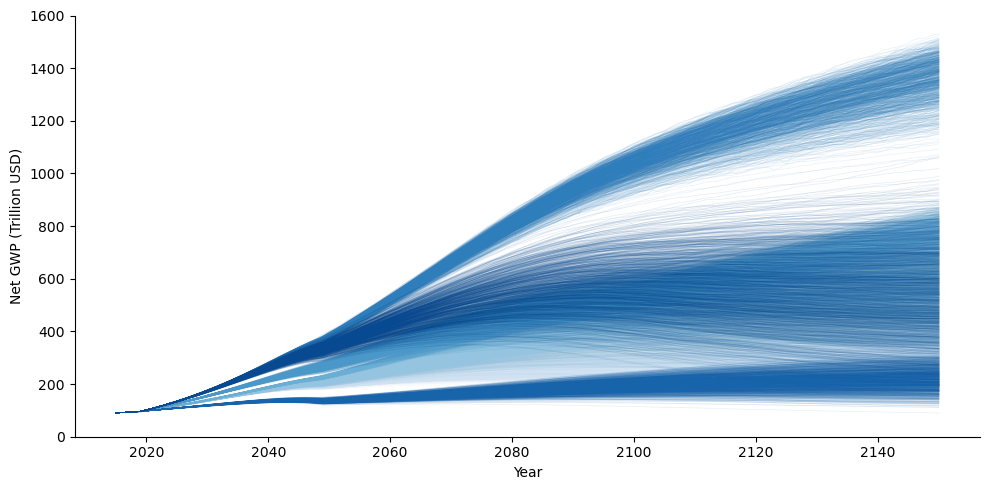

In [2]:
import pandas as pd
from src.util.model_time import TimeHorizon
import matplotlib.pyplot as plt

# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)


outcomes.keys()
experiments.columns

experiments_parameters = experiments[['damage_share_ratio_tfp', 'ssp_rcp_scenario']]


temperature = outcomes['net_economic_output']

#temperature is of shape (10, 286, 1001) where 10 is the number of scenarios, 286 is the number of timesteps and 1001 is the number of climate ensembles

# Plot all scenarios in the same plot
plt.figure(figsize=(10,5))
for i in range(10):
    # Color the lines by the scenario
    temp_per_scenario = pd.DataFrame(temperature[i, :, :].T)
    temp_per_scenario.columns = time_horizon.model_time_horizon

    # Select up until year 2150
    temp_per_scenario = temp_per_scenario.loc[:, :2150]
    temp_per_scenario = temp_per_scenario.T
    
    plt.plot(temp_per_scenario, color=plt.cm.Blues(i/10), alpha=0.1, linewidth=0.5)
plt.xlabel('Year')
plt.ylabel('Net GWP (Trillion USD)')

# Set y axis limits
plt.ylim(0, 1600)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Tight layout
plt.tight_layout()



# plt.ylabel('Temperature Rise (°C)')

plt.show()



# Update temperature column with time horizon
# temperature.columns = time_horizon.model_time_horizon


# Concatenate the experiments_parameters and temperature
# df_concat = pd.concat([experiments_parameters, temperature], axis=1)


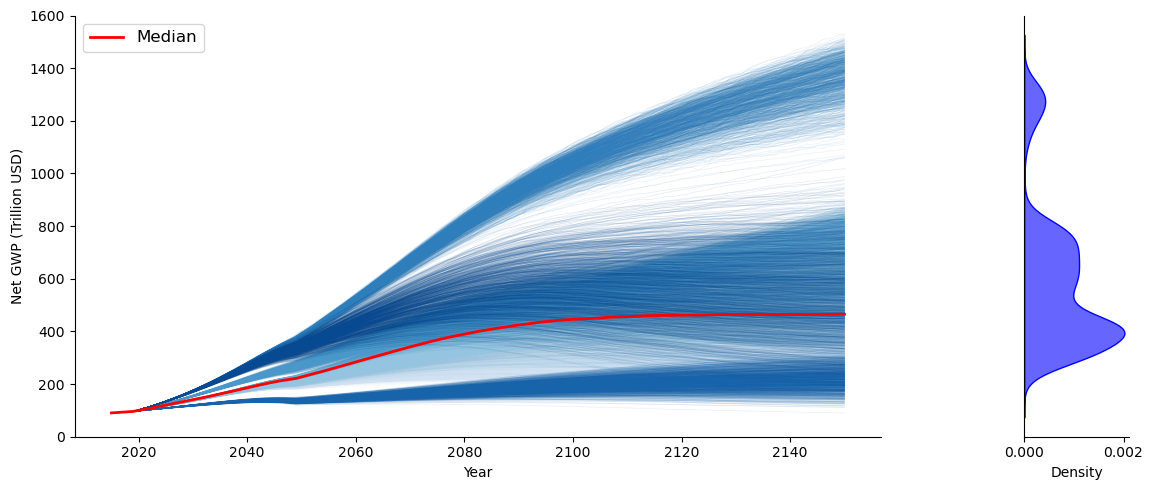

In [3]:

import pandas as pd
import numpy as np
from src.util.model_time import TimeHorizon
import matplotlib.pyplot as plt
import seaborn as sns

# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

outcomes.keys()
experiments.columns

experiments_parameters = experiments[['damage_share_ratio_tfp', 'ssp_rcp_scenario']]

temperature = outcomes['net_economic_output']

# Plot all scenarios in the same plot
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

last_year  = 2150

for i in range(temperature.shape[0]):
    # Color the lines by the scenario
    temp_per_scenario = pd.DataFrame(temperature[i, :, :].T)
    temp_per_scenario.columns = time_horizon.model_time_horizon

    # Select up until year 2150
    temp_per_scenario = temp_per_scenario.loc[:, 2015:last_year]
    temp_per_scenario = temp_per_scenario.T
    
    ax[0].plot(temp_per_scenario, color=plt.cm.Blues(i/10), alpha=0.1, linewidth=0.5)

# Calculate median over all scenarios for time series plot
median_data = np.median(temperature[:, time_horizon.model_time_horizon <= last_year], axis=(0, 2))
ax[0].plot(time_horizon.model_time_horizon[time_horizon.model_time_horizon <= last_year], median_data, color='red', alpha=1, linewidth=2, label="Median")

# Select the last year of the data for the KDE plot
temp_df_last_year = temperature[:, time_horizon.model_time_horizon == last_year, :].flatten()

# Plot the KDE plot
sns.kdeplot(y=temp_df_last_year, color='blue', ax=ax[1], fill=True, alpha=0.6)

# Adjust space between subplots
plt.subplots_adjust(wspace=0.001)  # Change this value to adjust spacing

# Adjust the width of the KDE plot
ax[1].set_box_aspect(4)  # Increase the height-to-width ratio

# Set labels and titles
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Net GWP (Trillion USD)')
ax[0].set_ylim(0, 1600)
ax[0].legend(loc="upper left", fontsize=12)

ax[1].set_xlabel("Density")
# ax[1].set_ylabel("Net GWP (Trillion USD)")

# Remove top and right spines for both plots
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

# Remove y-axis ticks for the KDE plot
ax[1].set_yticks([])




# Tight layout
plt.tight_layout()

plt.show()


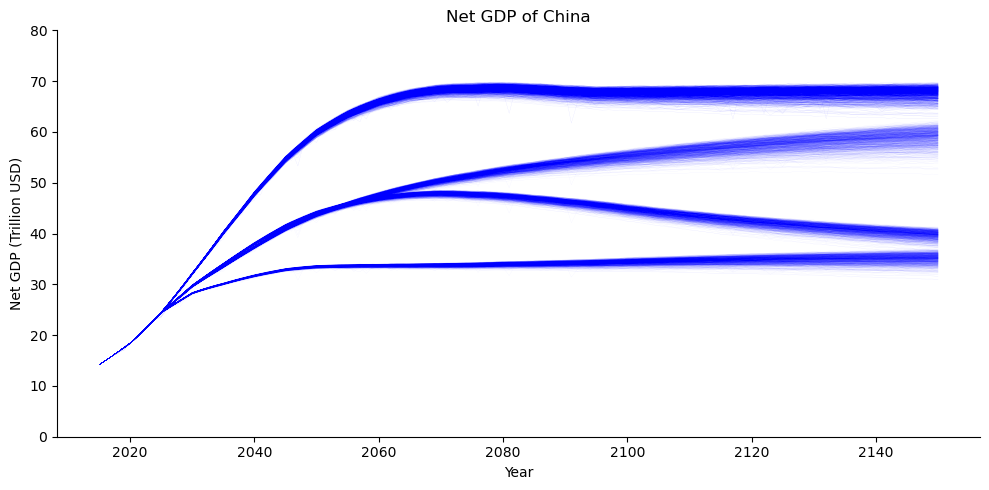

In [7]:
import pandas as pd
from src.util.model_time import TimeHorizon
import matplotlib.pyplot as plt

# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)


#nde 28, chn 9, rsaf 43, usa 54
region_index = 9
# net_output_country = net_output[54, :, :]

#temperature is of shape (10, 286, 1001) where 10 is the number of scenarios, 286 is the number of timesteps and 1001 is the number of climate ensembles

# Plot all scenarios in the same plot
plt.figure(figsize=(10,5))

for idx, scenarios in enumerate( ['SSP119', 'SSP245', 'SSP370', 'SSP434', 'SSP585'] ):
    datasets_scenario = scenario_data[scenarios]

    net_output_country = datasets_scenario['net_economic_output']
    net_output_country = pd.DataFrame(net_output_country[region_index, :, :])
    # Color the lines by the scenario
    temp_per_scenario = pd.DataFrame(net_output_country.T)
    temp_per_scenario.columns = time_horizon.model_time_horizon

    # Select up until year 2150
    temp_per_scenario = temp_per_scenario.loc[:, :2150]
    temp_per_scenario = temp_per_scenario.T

    plt.plot(temp_per_scenario, color='blue', alpha=0.1, linewidth=0.1)
plt.xlabel('Year')
plt.ylabel('Net GDP (Trillion USD)')

# Title
plt.title('Net GDP of China')

# Set y axis limits
plt.ylim(0, 80)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Tight layout
plt.tight_layout()



# plt.ylabel('Temperature Rise (°C)')

plt.show()



# Update temperature column with time horizon
# temperature.columns = time_horizon.model_time_horizon


# Concatenate the experiments_parameters and temperature
# df_concat = pd.concat([experiments_parameters, temperature], axis=1)


In [ ]:
# Get all the keys from outcomes that end in '_global_temperature'
temperature_keys = [key for key in outcomes.keys() if key.endswith('_global_temperature')]

# Concatenate the temperature in a single dataframe retain the original index
temperature_df_combined = pd.concat([pd.DataFrame(outcomes[key]) for key in temperature_keys], axis=0)

temperature_df_combined.columns = time_horizon.model_time_horizon

# Repeat experiments_parameters and combine the rows
experiments_parameters_combined = pd.concat([experiments_parameters]*len(temperature_keys), axis=0)


In [3]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px

data =  outcomes['global_temperature'] #temperature_df_combined

# Create a subplot figure
fig = make_subplots(rows=1, cols=2, subplot_titles=("Global Temperature Rise", "Damage Share Ratio TFP vs SSP RCP Scenario"))

# Set figure size
fig.update_layout(width=1200, height=600)

# White grid style
fig.update_layout(template="plotly_white")

# Add the temperature rise timeseries to the first subplot
for i in range(data.shape[0]):
    data_per_scenario = pd.DataFrame(data[i, :, :].T)
    data_per_scenario.columns = time_horizon.model_time_horizon
    # Select up until year 2150
    data_per_scenario = data_per_scenario.loc[:, 2015:2150]
    
    for j in range(data_per_scenario.shape[0]):
        
        fig.add_trace(
            go.Scatter(
                x=data_per_scenario.columns,
                y=data_per_scenario.iloc[j, :], #
                mode='lines',
                name=f"Scenario {i+1}",  # Naming traces for legend
                hoverinfo="x+y+name",
                opacity=0.1,
                line=dict(color=px.colors.qualitative.Light24[i % len(px.colors.qualitative.Light24)], width=0.5)
            ),
            row=1, col=1
        )

# Add the scatter plot to the second subplot
for index, row in experiments.iterrows(): #_parameters_combined

    fig.add_trace(
        go.Scatter(
            x=[row['damage_share_ratio_tfp']],
            y=[row['ssp_rcp_scenario']],
            mode='markers',
            text=f"Index {index}",
            hoverinfo="x+y+text",
            
            marker=dict(color=px.colors.qualitative.Light24[index % len(px.colors.qualitative.Light24)], size=10)
        ),
        row=1, col=2
    )

# Update the layout for both plots
fig.update_layout(
    title= "",#"Combined Plot of Global Temperature Rise and Damage Share Ratio TFP vs SSP RCP Scenario",
    showlegend=False
)

fig.update_xaxes(title_text="Year", row=1, col=1)
fig.update_yaxes(title_text="Temperature Rise (°C)", row=1, col=1)
fig.update_xaxes(title_text="Damage Share Ratio TFP", row=1, col=2)
fig.update_yaxes(title_text="SSP RCP Scenario", row=1, col=2)

# Save the figure
fig.write_image("data/plots/global_temperature_ants.png");


In [4]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
import plotly.colors as colors

# Sample data (replace these with your actual data)
data = outcomes['global_temperature']  # temperature_df_combined

# Create a subplot figure
fig = make_subplots(rows=1, cols=2, subplot_titles=("Global Temperature Rise", "Damage Share Ratio TFP vs SSP RCP Scenario"))

# Set figure size
fig.update_layout(width=1200, height=600)

# White grid style
fig.update_layout(template="plotly_white")

# Generate a list of colors using the magma color scale and discretize it based on the number of scenarios
num_scenarios = data.shape[0]
# num_samples = max(data.shape[1], len(experiments))

num_samples = max(data.shape[1], len(experiments))
color_scale = px.colors.diverging.RdYlBu_r
# Adjust the number of points you sample to create more contrast
num_colors = num_scenarios
colors_list = colors.sample_colorscale(color_scale, [i / (num_colors - 1) for i in range(num_colors)])

# color_scale = px.colors.diverging.RdYlBu #sequential.RdBu
# colors_list = colors.sample_colorscale(color_scale, [i / (num_samples - 1) for i in range(num_samples)])

# Add the temperature rise timeseries to the first subplot
color_index = 0
for i in range(data.shape[0]):
    data_per_scenario = pd.DataFrame(data[i, :, :].T)
    data_per_scenario.columns = time_horizon.model_time_horizon
    # Select up until year 2150
    data_per_scenario = data_per_scenario.loc[:, 2015:2150]
    
    for j in range(data_per_scenario.shape[0]):
        
        fig.add_trace(
            go.Scatter(
                x=data_per_scenario.columns,
                y=data_per_scenario.iloc[j, :],
                mode='lines',
                name=f"Scenario {i+1}",  # Naming traces for legend
                hoverinfo="x+y+name",
                opacity=0.1,
                line=dict(color=colors_list[i], width=0.5)
            ),
            row=1, col=1
        )
        color_index += 1

# Restart the color index for the second subplot
color_index = 0

# Add the scatter plot to the second subplot
for index, row in experiments.iterrows():  # _parameters_combined

    fig.add_trace(
        go.Scatter(
            x=[row['damage_share_ratio_tfp']],
            y=[row['ssp_rcp_scenario']],
            mode='markers',
            text=f"Index {index}",
            hoverinfo="x+y+text",
            marker=dict(color=colors_list[index], size=10)
        ),
        row=1, col=2
    )
    color_index += 1

# Update the layout for both plots
fig.update_layout(
    title="",  # "Combined Plot of Global Temperature Rise and Damage Share Ratio TFP vs SSP RCP Scenario",
    showlegend=False
)

fig.update_xaxes(title_text="Year", row=1, col=1)
fig.update_yaxes(title_text="Temperature Rise (°C)", row=1, col=1)
fig.update_xaxes(title_text="Damage Share Ratio TFP", row=1, col=2)
fig.update_yaxes(title_text="SSP RCP Scenario", row=1, col=2)

# Save the figure
fig.write_image("data/plots/global_temperature_ants.png");

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Convert RGBA to hex colors
def rgba_to_hex(rgba):
    return '#{:02x}{:02x}{:02x}'.format(int(rgba[0]*255), int(rgba[1]*255), int(rgba[2]*255))

data =  temperature_df_combined

# Extract the last column
temperatures = data.iloc[:, -1]

# Normalize the temperature values to the range [0, 1]
norm = Normalize(vmin=temperatures.min(), vmax=temperatures.max())
normalized_temperatures = norm(temperatures)

# Create a colormap
cmap = plt.get_cmap('coolwarm')

# Map the normalized temperatures to colors
colors = [cmap(value) for value in normalized_temperatures]


# Create a subplot figure
fig = make_subplots(rows=1, cols=2, subplot_titles=("Global Temperature Rise", "Damage Share Ratio TFP vs SSP RCP Scenario"))

# Set figure size
fig.update_layout(width=1200, height=600)

# White grid style
fig.update_layout(template="plotly_white")

colors_hex = [rgba_to_hex(color) for color in colors]


# Add the temperature rise timeseries to the first subplot
for i in range(data.shape[0]):
    fig.add_trace(
        go.Scatter(
            x=data.columns,
            y=data.iloc[i, :],
            mode='lines',
            name=f"Scenario {i+1}",  # Naming traces for legend
            hoverinfo="x+y+name",
            line=dict(color=colors_hex[i])  # Use the color mapped based on temperature
            # line=dict(color=px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)])
        ),
        row=1, col=1
    )

# Reset index of experiments_parameters_combined
experiments_parameters_combined = experiments_parameters_combined.reset_index()
# Add the scatter plot to the second subplot
for index, row in experiments_parameters_combined.iterrows():
    fig.add_trace(
        go.Scatter(
            x=[row['damage_share_ratio_tfp']],
            y=[row['ssp_rcp_scenario']],
            mode='markers',
            text=f"Index {index}",
            hoverinfo="x+y+text",
            # marker=dict(color=px.colors.qualitative.Plotly[index % len(px.colors.qualitative.Plotly)], size=10)
            marker=dict(color=colors_hex[index], size=10)
        ),
        row=1, col=2
    )

# Update the layout for both plots
fig.update_layout(
    title="Combined Plot of Global Temperature Rise and Damage Share Ratio TFP vs SSP RCP Scenario",
    showlegend=False
)

fig.update_xaxes(title_text="Year", row=1, col=1)
fig.update_yaxes(title_text="Temperature Rise (°C)", row=1, col=1)
fig.update_xaxes(title_text="Damage Share Ratio TFP", row=1, col=2)
fig.update_yaxes(title_text="SSP RCP Scenario", row=1, col=2)

# Show the plot
fig.show()

In [ ]:
# Get all the keys from outcomes that end in '_global_temperature'
data_keys = [key for key in outcomes.keys() if key.endswith('_net_economic_output')]

# Combine the numpy arrays into a single numpy array
data_combined = np.concatenate([outcomes[key] for key in data_keys], axis=0)

# Choose a particular region
region_index = 55

# Extract the data for the region
region_data = data_combined[:, region_index, :]

# Region data is shape (600, 286) where 600 is the number of scenarios and 286 is the number of years
# Create a dataframe for the region data
region_df = pd.DataFrame(region_data)

# Set the column names to the years
region_df.columns = time_horizon.model_time_horizon

# Create a figure
fig = go.Figure()

# Add traces for each scenario
for i in range(region_df.shape[0]):
    fig.add_trace(
        go.Scatter(
            x=region_df.columns,
            y=region_df.iloc[i, :],
            mode='lines',
            name=f"Scenario {i+1}",
            line=dict(color=px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)])
        )
    )

# Update the layout
fig.update_layout(
    title=f"Net Economic Output for Region {region_index}",
    xaxis_title="Year",
    yaxis_title="Net Economic Output (Trillion USD)",
    showlegend=False
)

# Show the plot
fig.show()

